In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_path = '/content/drive/MyDrive/AI ML/Copy of Copy of devnagari digit.zip'
extract_path = '/content/AI ML/devnagari_dataset'  # or any directory you prefer

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# **Dataset Preparation and Preprocessing**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [ ]:
# Load and preprocess MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape to (28, 28, 1)
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add Gaussian noise
noise_factor_low = 0.1
noise_factor_high = 0.5

In [ ]:
x_train_noisy_low = x_train + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy_high = x_train + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy_low = x_test + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy_high = x_test + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip to [0, 1]
x_train_noisy_low = np.clip(x_train_noisy_low, 0., 1.)
x_train_noisy_high = np.clip(x_train_noisy_high, 0., 1.)
x_test_noisy_low = np.clip(x_test_noisy_low, 0., 1.)
x_test_noisy_high = np.clip(x_test_noisy_high, 0., 1.)

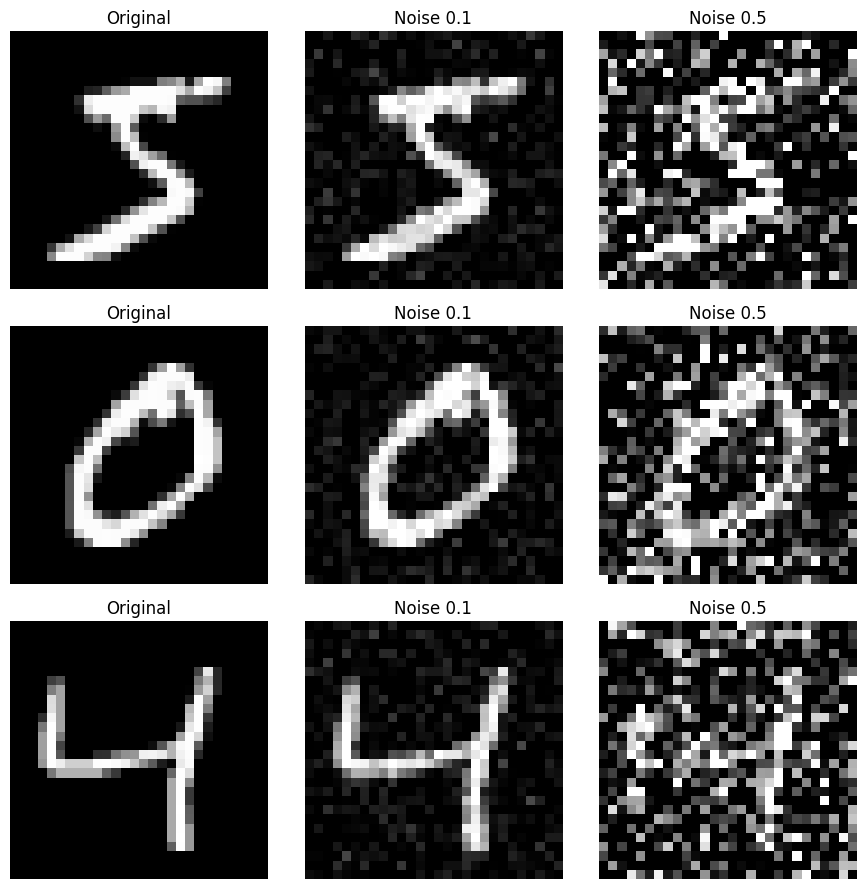

In [ ]:
# Visualize: Original, Low Noise, High Noise
n = 3
plt.figure(figsize=(9, 9))
for i in range(n):
    # Original
    ax = plt.subplot(n, 3, i * 3 + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Low noise
    ax = plt.subplot(n, 3, i * 3 + 2)
    plt.imshow(x_train_noisy_low[i].reshape(28, 28), cmap='gray')
    plt.title("Noise 0.1")
    plt.axis('off')

    # High noise
    ax = plt.subplot(n, 3, i * 3 + 3)
    plt.imshow(x_train_noisy_high[i].reshape(28, 28), cmap='gray')
    plt.title("Noise 0.5")
    plt.axis('off')

plt.tight_layout()
plt.show()

# **Build the Denoising Convolutional Autoencoder**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

# Input shape
input_img = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)   # Layer 1
x = MaxPooling2D((2, 2), padding='same')(x)                            # Downsample
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)           # Layer 2
x = MaxPooling2D((2, 2), padding='same')(x)                            # Downsample

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)           # Layer 3
x = UpSampling2D((2, 2))(x)                                            # Upsample
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)           # Layer 4
x = UpSampling2D((2, 2))(x)                                            # Upsample
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)   # Output layer

# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

# **Train the model**

In [ ]:
# Training the model
history = autoencoder.fit(
    x_train_noisy_low, x_train,
    epochs=10,  # You can increase for better results
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy_low, x_test)
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 112s 234ms/step - loss: 0.1825 - val_loss: 0.0762
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 139s 228ms/step - loss: 0.0752 - val_loss: 0.0718
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 138s 219ms/step - loss: 0.0721 - val_loss: 0.0703
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 147s 231ms/step - loss: 0.0708 - val_loss: 0.0698
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 137s 221ms/step - loss: 0.0698 - val_loss: 0.0688
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 218ms/step - loss: 0.0692 - val_loss: 0.0682
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 216ms/step - loss: 0.0685 - val_loss: 0.0678
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 219ms/step - loss: 0.0682 - val_loss: 0.0675
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 217ms/step - loss: 0.0677 - val_loss: 0.0671
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 103s 220ms/step - loss: 0.0675 - val_loss: 0.0670


# **Plot the Loss Curves**

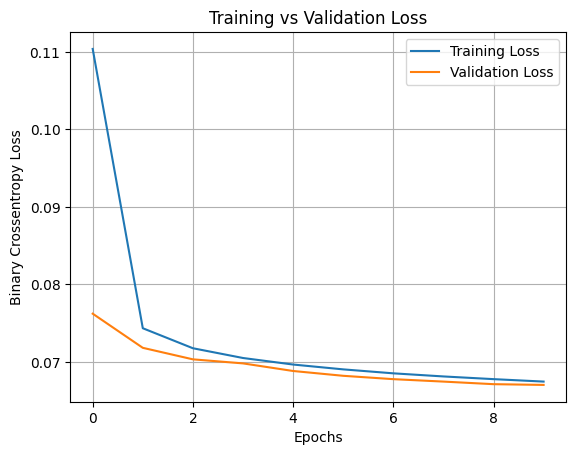

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# **Visualize the Output**

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


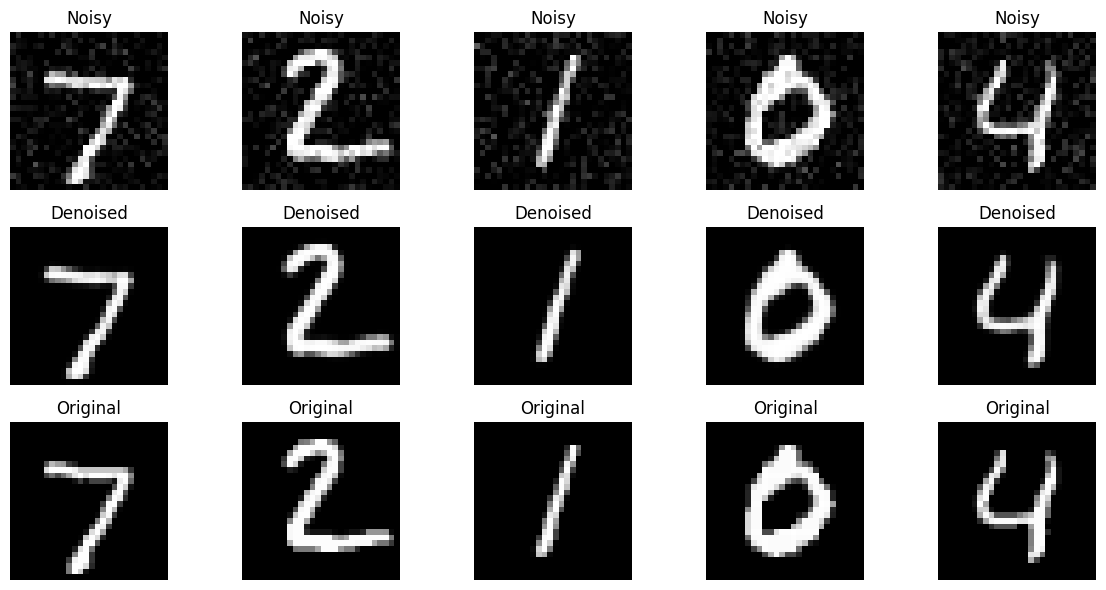

In [ ]:
# Get denoised predictions
decoded_imgs = autoencoder.predict(x_test_noisy_low)

# Visualize
n = 5
plt.figure(figsize=(12, 6))
for i in range(n):
    # Noisy
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy_low[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Denoised
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')

    # Original
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

plt.tight_layout()
plt.show()